In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv("/home/eiji/project/g/preprocessed_data/GarageDoor_GD-MM.csv")
data

,hour,minute,second,sphone_signal_0,sphone_signal_1,door_state_open,door_state_closed,label
0,0.869565,0.898305,0.745763,0,1,1,0,0
1,0.869565,0.898305,0.830508,1,0,0,1,0
2,0.869565,0.898305,0.830508,0,1,1,0,0
3,0.869565,0.898305,0.915254,1,0,0,1,0
4,0.869565,0.898305,0.915254,0,1,1,0,0
...,...,...,...,...,...,...,...,...
541172,0.478261,0.050847,0.355932,1,0,0,1,0
541173,0.478261,0.050847,0.355932,1,0,0,1,0
541174,0.478261,0.050847,0.355932,1,0,0,1,0
541175,0.478261,0.050847,0.372881,1,0,0,1,0


In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2024-08-22 20:28:15.916375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 20:28:15.944756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 20:28:16.347422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-22 20:28:16.627356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

In [3]:
X = data[['hour', 'minute', 'second', 'sphone_signal_0', 'sphone_signal_1', 'door_state_open', 'door_state_closed']].values
y = data['label'].values

In [4]:
window_size = 30
X_windows = []
y_windows = []

for i in range(len(X) - window_size + 1):
    X_windows.append(X[i:i + window_size])
    y_windows.append(y[i + window_size - 1])  # ラベルはウィンドウの最後のデータに対応させます

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)


# トレーニングデータとテストデータに分割
X_train, X_temp, y_train, y_temp = train_test_split(X_windows, y_windows, test_size=0.3, random_state=42, stratify=y_windows)
# テストデータをさらに検証データとテストデータに分割
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTMモデルの構築
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# モデルのコンパイル
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# モデルの概要
model.summary()

/home/eiji/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,651 (45.51 KB)

 Trainable params: 11,651 (45.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# モデルの訓練
# モデルの訓練
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1, shuffle=False)


Epoch 1/10


I0000 00:00:1724326104.025045   88494 service.cc:145] XLA service 0x7a0ce000a3e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724326104.025065   88494 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-08-22 20:28:24.046861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  47/5919 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7822 - loss: 0.5271    

I0000 00:00:1724326104.341518   88494 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5919/5919 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8589 - loss: 0.3609 - val_accuracy: 0.8596 - val_loss: 0.3461
Epoch 2/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8739 - loss: 0.3040 - val_accuracy: 0.9222 - val_loss: 0.2021
Epoch 3/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9322 - loss: 0.1818 - val_accuracy: 0.9539 - val_loss: 0.1293
Epoch 4/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9446 - loss: 0.1477 - val_accuracy: 0.9426 - val_loss: 0.1502
Epoch 5/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9509 - loss: 0.1344 - val_accuracy: 0.9560 - val_loss: 0.1192
Epoch 6/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9628 - loss: 0.1046 - val_accuracy: 0.9681 - val_loss: 0.0920
Epoch 7/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9670 - loss: 0.0927 - val_accuracy: 0.9727 - val_loss: 0.0819
Epoch 8/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9690 - loss: 0.0853 - val

In [7]:
# モデルの評価
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

2537/2537 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9740 - loss: 0.0778
Test Accuracy: 0.9737


2537/2537 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


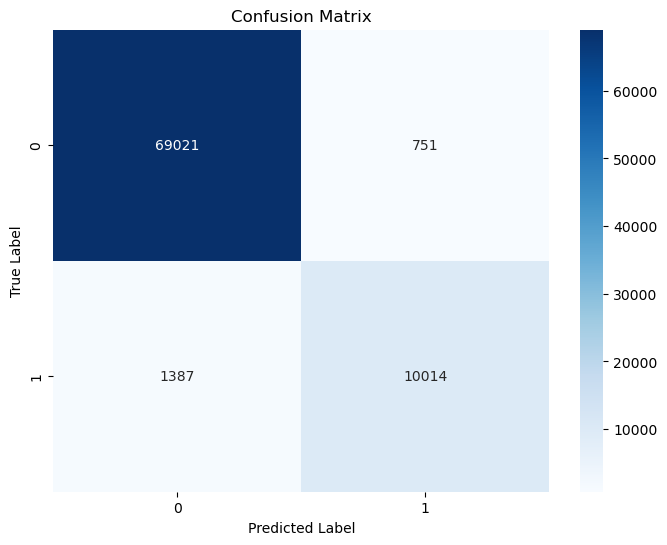

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     69772
           1       0.93      0.88      0.90     11401

    accuracy                           0.97     81173
   macro avg       0.96      0.93      0.94     81173
weighted avg       0.97      0.97      0.97     81173



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 予測の実行
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # 閾値0.5でクラスに変換

# 混同行列の計算
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 混同行列の表示
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 精度、適合率、再現率、F1スコアのレポート
print(classification_report(y_test, y_pred_classes))


In [ ]:
import tensorflow as tf

# TensorFlowのバージョンを確認
print("TensorFlow version:", tf.__version__)

# 利用可能なGPUリストを表示
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))
